## BalanceNet prototype

In [1]:
%run Setup.ipynb
%run ExtraFunctions.ipynb
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'
import itertools, pickle

[i] Loaded Parameters:
 40000 35 0.2 200 
 data/glove/glove.twitter.27B.200d.txt
[i] Importing Modules...


Using TensorFlow backend.


[+] Using Keras version 2.2.4
[+] Finished Importing Modules
[i] Reading from csv file...Done!
[i] Found 34359 unique tokens.
[+] Shape of data tensor: (38994, 30)
[+] Shape of label tensor: (38994, 6)


/Users/cristianlomeli/Documents/CS224U/CS224U-Final/.env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


[i] Number of entries in each category:
[+] Training:
 [9135 9139 9176 9146 9174 9223]
[+] Validation:
 [2322 2318 2281 2311 2283 2234]


FileNotFoundError: [Errno 2] No such file or directory: 'data/glove/glove.twitter.27B.200d.txt'

In [2]:
# second embedding matrix for non-static channel
embedding_matrix_ns = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_ns[i] = embedding_vector
print("Completed!")

Completed!


In [68]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# static channel
embedding_layer_frozen = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
embedded_sequences_frozen = embedding_layer_frozen(sequence_input)

# non-static channel
embedding_layer_train = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_ns],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences_train = embedding_layer_train(sequence_input)

In [46]:
l_lstm1f = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_frozen)
l_lstm1t = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_train)
l_lstm1 = Concatenate(axis=1)([l_lstm1f, l_lstm1t])

In [47]:
l_conv_2 = Conv1D(filters=24,kernel_size=2,activation='relu')(l_lstm1)
l_conv_2 = Dropout(0.5)(l_conv_2)
l_conv_3 = Conv1D(filters=24,kernel_size=3,activation='relu')(l_lstm1)
l_conv_3 = Dropout(0.5)(l_conv_3)

l_conv_5 = Conv1D(filters=24,kernel_size=5,activation='relu',)(l_lstm1)
l_conv_5 = Dropout(0.5)(l_conv_5)
l_conv_6 = Conv1D(filters=24,kernel_size=6,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_6 = Dropout(0.5)(l_conv_6)

l_conv_8 = Conv1D(filters=24,kernel_size=8,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_8 = Dropout(0.5)(l_conv_8)

conv_1 = [l_conv_6,l_conv_5, l_conv_8,l_conv_2,l_conv_3]

l_lstm_c = Concatenate(axis=1)(conv_1)

In [48]:
l_conv_4f = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_frozen)
l_conv_4f = Dropout(0.5)(l_conv_4f)
l_conv_4t = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_train)
l_conv_4t = Dropout(0.5)(l_conv_4t)

l_conv_3f = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_frozen)
l_conv_3f = Dropout(0.5)(l_conv_3f)
l_conv_3t = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_train)
l_conv_3t = Dropout(0.5)(l_conv_3t)

l_conv_2f = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_frozen)
l_conv_2f = Dropout(0.5)(l_conv_2f)
l_conv_2t = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_train)
l_conv_2t = Dropout(0.5)(l_conv_2t)

conv_2 = [l_conv_4f, l_conv_4t,l_conv_3f, l_conv_3t, l_conv_2f, l_conv_2t]

l_merge_2 = Concatenate(axis=1)(conv_2)
l_c_lstm = Bidirectional(LSTM(12,return_sequences=True,dropout=0.5, recurrent_dropout=0.0))(l_merge_2)

Combine both halfs of the model

In [49]:
l_merge = Concatenate(axis=1)([l_lstm_c, l_c_lstm])
l_pool = MaxPooling1D(3)(l_merge)
l_drop = Dropout(0.5)(l_pool)
l_flat = Flatten()(l_drop)
l_dense = Dense(26, activation='relu')(l_flat)
preds = Dense(6, activation='softmax')(l_dense)

In [50]:
model = Model(sequence_input, preds)
adadelta = optimizers.Adam()
lr_metric = get_lr_metric(adadelta)
model.compile(loss='categorical_crossentropy',
              optimizer=adadelta,
              metrics=['acc'])

In [51]:
tensorboard = callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=16, write_grads=True , write_graph=True)
lr_schedule = callbacks.LearningRateScheduler(initial_boost)

In [52]:
model.summary()
model.save('BalanceNetAdam6_50.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 200)      6872000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 30, 200)      6872000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 30, 12)       9936        embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectio

In [3]:
model = keras.models.load_model("6better.h5")
from keras.utils import plot_model
plot_model(model, to_file='BalanceNetAdam6_50.png')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [271]:
model = keras.models.load_model('6better.h5')

Time to train!!

In [92]:
print("Training Progress:")
model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=5, batch_size=128,
          callbacks=[tensorboard])

# model.save('better3.h5')
# pd.DataFrame(model_log.history).to_csv("history-balance.csv")

Training Progress:
Train on 54993 samples, validate on 13749 samples
Epoch 1/5
54993/54993 [==============================] - 151s 3ms/step - loss: 0.8183 - acc: 0.6775 - val_loss: 1.0214 - val_acc: 0.6134
Epoch 2/5
51584/54993 [===========================>..] - ETA: 22s - loss: 0.7568 - acc: 0.7052

KeyboardInterrupt: 

In [82]:
model.save('6better1_3.h5')

## Model Testing and Inference

In [83]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'
import itertools, pickle

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

classes = ['sadness', 'worry', 'love', 'hate', 'happiness', 'neutral']

In [84]:
model_test = load_model('6better1_2.h5')
Y_test = np.argmax(y_val, axis=1) # Convert one-hot to index
y_pred = model_test.predict(x_val)
y_pred_class = np.argmax(y_pred,axis=1)
cnf_matrix = confusion_matrix(Y_test, y_pred_class)

In [85]:
print(classification_report(Y_test, y_pred_class, target_names=classes))

              precision    recall  f1-score   support

     sadness       0.49      0.74      0.59      2290
       worry       0.37      0.31      0.34      2337
        love       0.76      0.75      0.76      2270
        hate       0.91      0.96      0.93      2272
   happiness       0.43      0.38      0.40      2264
     neutral       0.57      0.42      0.48      2316

    accuracy                           0.59     13749
   macro avg       0.59      0.59      0.58     13749
weighted avg       0.59      0.59      0.58     13749



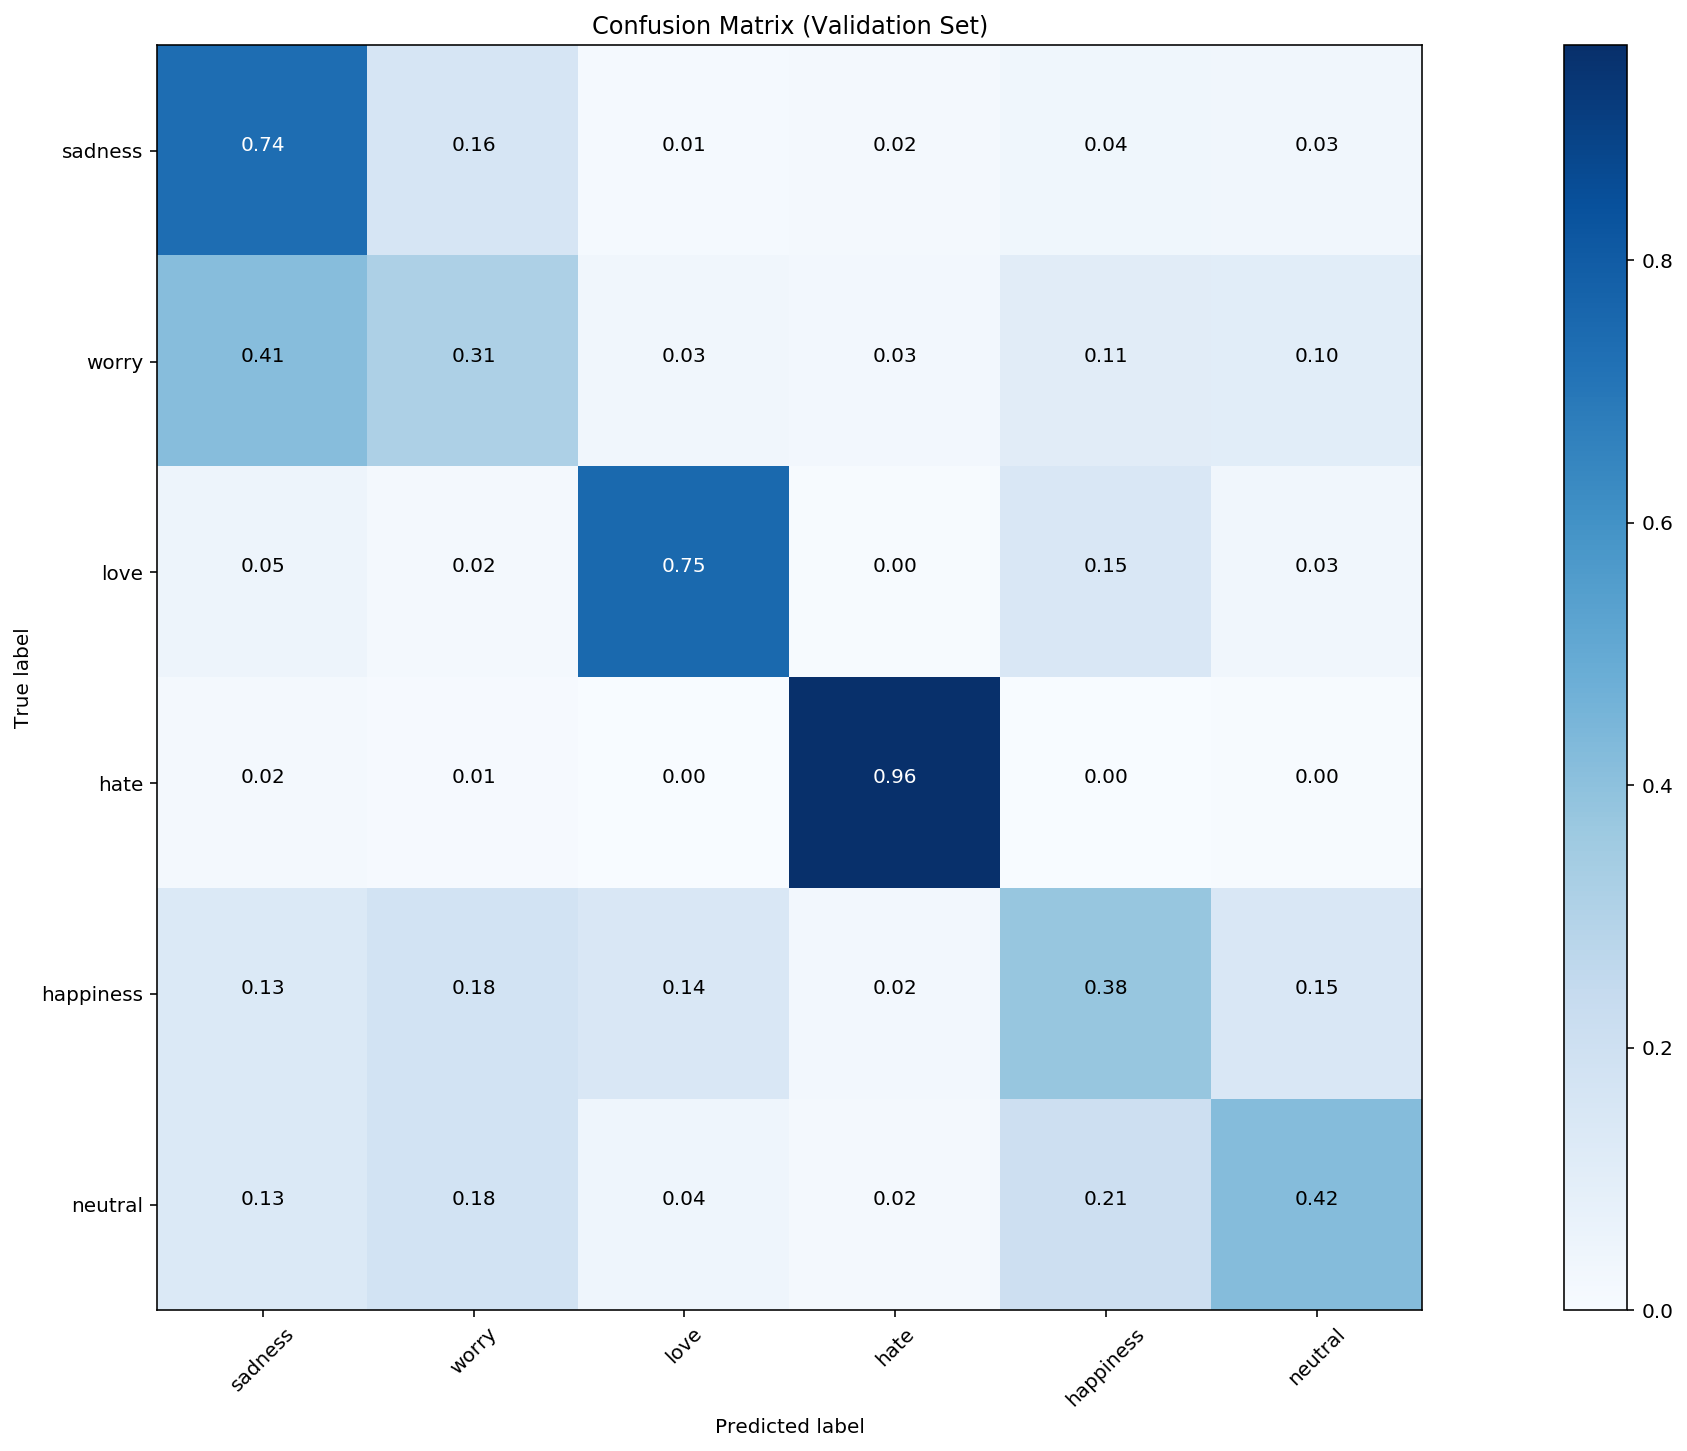

In [86]:
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, labels=classes)

# precision = true_pos / (true_pos + false_pos)
# recall = true_pos / (true_pos + false_neg)

model = load_model('6better.h5')

In [88]:
model = load_model('6better1_2.h5')

In [13]:
text = ["I salute you for the bravery and sacrifice! A true hero indeed.",
        "i am worried",
        "Austin smells like flowers",
        "fucking",
        "You are such a mean ass bitch dumb mom",
        "what a nuisance fk. a proper clean and flat footpath,,now obstructed by sharedbikes..! which idiotic MP allowed this to happen?",
        "what the fuck you are so stupid",
        "i am not sad"
       ]

In [89]:
# feat_extractor = Model(inputs=model_test.input, outputs=model.get_layer("dense_2").output)

sequences_test = tokenizer.texts_to_sequences(text)
data_int_t = pad_sequences(sequences_test, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH))
data_test = pad_sequences(data_int_t, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))
y_prob = model.predict(data_test)
# print(type(y_prob))
for n, prediction in enumerate(y_prob):
    pred = y_prob.argmax(axis=-1)[n]
    print(text[n],"\nPrediction:",classes[pred],"\n")

I salute you for the bravery and sacrifice! A true hero indeed. 
Prediction: love 

i am worried 
Prediction: worry 

Austin smells like flowers 
Prediction: sadness 

fucking 
Prediction: hate 

You are such a mean ass bitch dumb mom 
Prediction: hate 

what a nuisance fk. a proper clean and flat footpath,,now obstructed by sharedbikes..! which idiotic MP allowed this to happen? 
Prediction: worry 

what the fuck you are so stupid 
Prediction: hate 

i am not sad 
Prediction: sadness 



In [5]:
DATA_FOLDER = "data/parsed2_imsdb/"

In [12]:
seen = []
for genre in list(os.listdir(DATA_FOLDER)):
        if not genre.endswith(".DS_Store"):
            genre_folder = DATA_FOLDER + genre
            for i, film in enumerate(list(os.listdir(genre_folder))):
                if film.endswith('.txt') and film not in seen:
                    sentences = []
                    with open(genre_folder + '/' + film, 'r') as file:
                        sentences = file.read().splitlines()
                    sentences = sentences[15:]
                    sequences_test = tokenizer.texts_to_sequences(sentences)
                    data_int_t = pad_sequences(sequences_test, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH))
                    data_test = pad_sequences(data_int_t, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))
                    y_prob = model.predict(data_test)
                    np.savetxt('data/emotion_vectors/' + film, y_prob)
                    seen.append(film)
                    print(len(seen))
#                     print(film, y_prob)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [93]:
with open('data/parsed2_imsdb/Horror/alien.txt') as f:
    lines = f.read().splitlines()

In [95]:
sequences_test = tokenizer.texts_to_sequences(lines)
data_int_t = pad_sequences(sequences_test, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH))
data_test = pad_sequences(data_int_t, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))
y_prob = model.predict(data_test)
np.savetxt('alien_emotion.txt', y_prob)
print(y_prob)
for n, prediction in enumerate(y_prob):
    pred = y_prob.argmax(axis=-1)[n]
    print(lines[n],"\nPrediction:",classes[pred],"\n")

[[2.9372567e-01 6.4475703e-01 3.1841244e-06 4.6143039e-05 1.9121736e-02
  4.2346388e-02]
 [1.8056910e-03 2.1528476e-01 1.4379325e-05 1.8659355e-07 1.5584323e-01
  6.2705177e-01]
 [1.7810562e-04 5.7890113e-02 1.6183085e-04 9.7667003e-09 1.1246944e-01
  8.2930046e-01]
 ...
 [4.0039144e-02 5.5646104e-01 1.2054103e-05 1.5549293e-05 4.5517311e-02
  3.5795498e-01]
 [1.0660759e-03 4.9382720e-02 5.4389421e-02 5.4521943e-09 8.0005163e-01
  9.5110103e-02]
 [7.1406230e-02 2.8044796e-01 5.3396514e-03 5.8052596e-03 1.8077648e-01
  4.5622444e-01]]
alien early draft by dan obannon project formerly titled story by dan obannon ronald shusett screenplay by dan obannon en route back to earth from a far part of the 
Prediction: worry 

galaxy the crew of the starship snark intercepts a transmission in an alien language originating from a nearby storm shrouded planet 
Prediction: neutral 

mankind has waited centuries to contact another form of intelligent life in the universe they decide to land and inves

it is a holy christ 
Prediction: neutral 

standard shines his light on the console at which the hideous skeleton is seated 
Prediction: sadness 

he moves his light closer and peers at the panel 
Prediction: worry 

look at this 
Prediction: neutral 

something has been scratched here 
Prediction: neutral 

into the veneer 
Prediction: neutral 

traced raggedly onto the surface of the panel as by the point of a sharp instrument is a small triangle hearing something broussard flashes his light across the room 
Prediction: happiness 

as the beam scans the walls it briefly touches on something that moves 
Prediction: neutral 

melkonis convulsively yanks out his pistol 
Prediction: sadness 

standard knocks his hand down 
Prediction: neutral 

keep away from that gun 
Prediction: neutral 

standard shoulders himself in front of the others 
Prediction: neutral 

then slowly he begins to move toward the far side of the room 
Prediction: happiness 

they approach a console on the wall trai

faust takes a pair of pliers from a rack and carefully grasps the tip of one of the tentacles 
Prediction: worry 

squeezing tightly he leans back with all his weight 
Prediction: neutral 

grabbing fausts hands stop it youre tearing his face 
Prediction: hate 

a trickle of blood begins to ooze down broussards cheek 
Prediction: happiness 

its not coming off not without his whole face coming off too 
Prediction: sadness 

lets let the machine work on him 
Prediction: happiness 

efficiently they strip broussard naked then standard presses a couple of switches on the wall 
Prediction: worry 

the machine lights up and broussard is sucked into the slot in the wall 
Prediction: worry 

he is visible inside 
Prediction: neutral 

the machine immediately sprays a cloud of disinfectant on him then sterilizes him with a blinding pink light 
Prediction: happiness 

a bank of video monitors pops on revealing x ray images of different parts of his body 
Prediction: worry 

sensors begin to sca

smiles at him were the new pioneers chaz 
Prediction: sadness 

we even have our own special diseases 
Prediction: happiness 

come on lets go above and see how theyre coming with the gear 
Prediction: happiness 

the whole crew has assembled 
Prediction: neutral 

faust is unfolding several yards of shimmering metallic netting 
Prediction: neutral 

hunter hands out five thin rods like metal broom handles 
Prediction: worry 

these have portable generators in them 
Prediction: hate 

theyre insulated down to here just be careful not to touch the end 
Prediction: sadness 

he demonstrates by touching the tip of one of the rods to a metal object 
Prediction: sadness 

a blue spark leaps 
Prediction: happiness 

might even incinerate the damn thing 
Prediction: neutral 

sharply i hope not 
Prediction: neutral 

dont worry it wont damage it itll just give it a little incentive 
Prediction: worry 

how do we locate the creature 
Prediction: neutral 

he picks up a small portable unit 
Pre

he unfolds his paper turns it so the others can see it 
Prediction: happiness 

it has a big x on it 
Prediction: neutral 

another angle shortly later 
Prediction: neutral 

hunter is showing roby a small device like a transistor radio 
Prediction: worry 

just keep your finger off the button till shes way away from the ship thats all 
Prediction: worry 

is it armed 
Prediction: neutral 

if you press the button right now it will blow the whole nose of the ship off 
Prediction: hate 

thanks for the thought 
Prediction: happiness 

puts detonator in his breast pocket all right martin well be in touch with you on the communicator 
Prediction: neutral 

and youll let me know when youve got it coming this way 
Prediction: neutral 

and you stand aside while we drive it in then shut the hatch launch the boat and kablooey 
Prediction: sadness 

hunters face twitches nervously at this 
Prediction: sadness 

come on we havent much time air is a factor 
Prediction: happiness 

they leave the